In [1]:
import numpy as np
import scipy as sp
import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

import matplotlib.pyplot as plt
%matplotlib inline

Nonequilibrium
https://www.pnas.org/content/110/45/E4185

Sequence:
https://www.sciencedirect.com/science/article/pii/S0896627310000917

Structure:
https://www.cell.com/neuron/fulltext/S0896-6273(18)30543-9

## Hopfield model

## $\tau \frac { d u _ { i } } { d t } = - u _ { i }(t) + \sum _ { j = 1 } ^ { N } T _ { ij } f _ { j } \left( u _ { j } (t)\right) + I _ { i }(t)$

-Hopfield: $T_{ij}$ is PSD

-Multi-attractor: $T_{ij}$ is constructed by multiple tuning curves

-Functional feedforward: $T_{ij}$ is non-normal, with off-diagonal terms shown in Schur decomposition

-Seuqnece activity: $T_{ij}$ has dominating elements along $i^{th}$ rows and the convarinace matrix would be eye-like

In [732]:
###Tij matrix
N = 20
temp = np.random.randn(1,N)
T = np.dot(temp.T,temp)
np.fill_diagonal(T,0)
T = T/N

K = 5  #number of patterns to store
T = np.zeros((N,N))
for ii in range(K):
    rv = np.random.randn(1,N)
    u,s,v = np.linalg.svd(np.dot(rv.T,rv))  #make orthogonal vectors
    T = T + np.outer(u[:,ii],u[:,ii])  #store in Hopfield
np.fill_diagonal(T,0)
T = T/(N*K)  #normalization


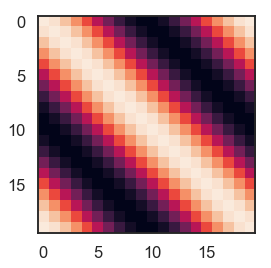

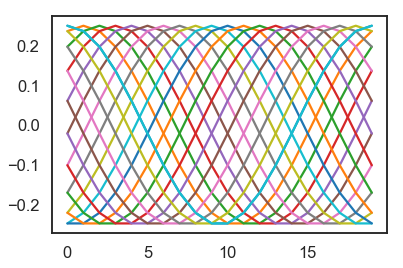

In [946]:
##multi-attractor model
T = np.zeros((N,N))  #connectivity matrix
deg2rad = np.pi/180
ths = np.linspace(-90,90,N)*deg2rad  #preferred tuning direction
for ii in range(N):
    for jj in range(N):
        T[ii,jj] = 0.5 + 1/N*np.cos((ths[ii]-ths[jj])/0.5)
T = (T-np.mean(T))*5  ##??

plt.imshow(T)
plt.figure()
plt.plot(T);

In [939]:
###functional feedforward
temp = np.random.randn(1,N)
T = np.dot(temp.T,temp)
u,s,v = np.linalg.svd(T)
temp2 = np.random.randn(N,N)
ss = np.diag(s) + np.triu(temp2, k=1)*20  #with feedforward term in Schur decomposition
T = u @ ss @ v
T = T/N

In [728]:
###sequence?
temp = np.random.randn(1,N)
T = np.dot(temp.T,temp)
temp2 = np.eye(N)
rr = np.arange(N)
np.random.shuffle(rr)
temp3 = np.take(temp2, rr, axis=0)  #seqeunce feedforward matrix
T = T + temp3*30
T = T/N

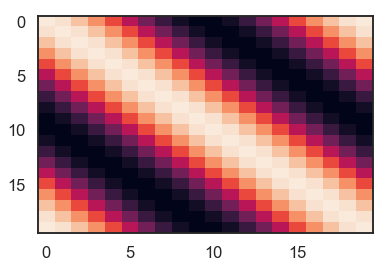

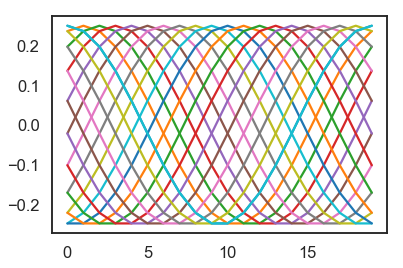

In [947]:
plt.imshow(T,aspect='auto')
plt.figure()
plt.plot(T);

In [987]:
###Nonlinearity
def NL(u,the,bound):
    NLed = np.array([max(ui-the,0) if (ui-the)<bound else bound for ui in u]) #ReLu with upper bound
    return NLed

###Dynamics
TT = 5
dt = 0.01
time = np.arange(0,TT,dt)
u = np.zeros((N,len(time)))
u[:,0] = np.random.randn(N)
tau = 0.05  #time scale
the = 0  #threshold
beta = .1  #global inhibition
bound = 100  #upper bound for activation

rep = 20  #instantiations
us = np.zeros((rep,N,len(time)))
for rr in range(rep):
    u[:,:-1] = 0
    u[:,0] = np.random.randn(N)*bound  #initial condition (scaled by a proper range!)
    u[:,-1] = 0
    for tt in range(0,len(time)-1):
        u[:,tt+1] = u[:,tt] + dt*(-u[:,tt] + np.dot(T,NL(u[:,tt]-beta*np.sum(u[:,tt]),the,bound)))/tau \
        + np.random.randn(N)*2.5
        #u[:,tt+1] = u[:,tt] + dt*(-u[:,tt] + NL(np.dot(T,u[:,tt])-beta*np.sum(u[:,tt]),the))/tau + np.random.randn(N)*1.  
    us[rr,:,:] = u
    #us.append(u)  ##???
    #plt.figure()
    #plt.imshow(u,aspect='auto')
    

Text(0, 0.5, 'activity')

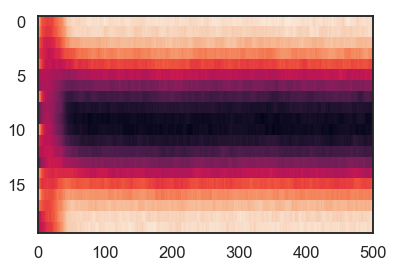

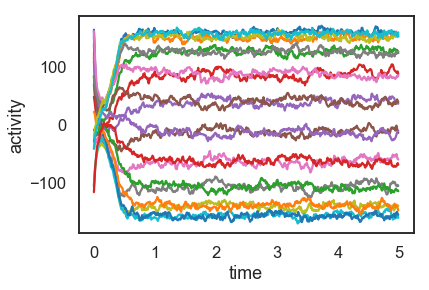

In [988]:
plt.imshow(u,aspect='auto')
plt.figure()
plt.plot(time,u.T);
plt.xlabel('time')
plt.ylabel('activity')

Text(0, 0.5, '|Y(freq)|')

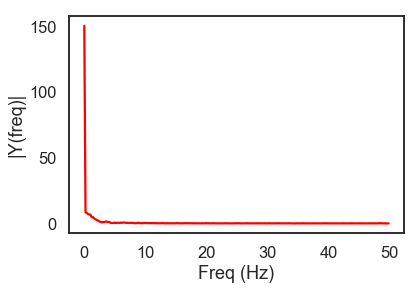

In [989]:
###Spectrum
Fs = int(1/dt);  # sampling rate
Ts = 1.0/Fs; # sampling interval

n = u.shape[1] # length of the signal
k = np.arange(n)
Tf = n/Fs
frq = k/Tf # two sides frequency range
frq = frq[range(int(n/2))] # one side frequency range

Y = np.fft.fft(u[0,:])/n # fft computing and normalization
Y = Y[range(int(n/2))]

plt.plot(frq[:],abs(Y)[:],'r') # plotting the spectrum
plt.xlabel('Freq (Hz)')
plt.ylabel('|Y(freq)|')


Text(0, 0.5, 'activity')

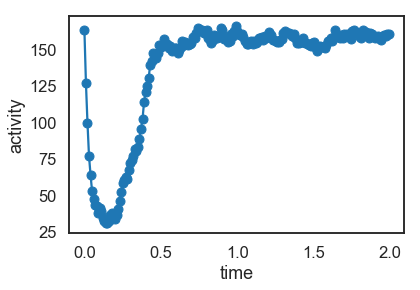

In [990]:
plt.plot(time[:200],u[0,:200].T,'-o');
plt.xlabel('time')
plt.ylabel('activity')

## Energy landscape

Fokker-Plank eqn
### $\frac{\partial P(u,t)}{\partial t} = -\frac{\partial}{\partial u}(FP - \frac{\partial}{\partial u} D P)$

Hopfield-like model
### $F = \tau \frac { d u _ { i } } { d t } = - u _ { i }(t) + \sum _ { j = 1 } ^ { N } T _ { ij } f _ { j } \left( u _ { j } (t)\right) + I _ { i }(t)$


Steady-state solution
### $P_{ss}(u) \propto exp(-\beta U(u))$

Approximate energy landscape (learned from sampling and GP?)
### $\frac{U(u)}{k_BT} = \beta U ( u ) = - \int _ { 0 } ^ { u } \frac { F \left( u ^ { \prime } \right) } { D \left( u ^ { \prime } \right) } d u ^ { \prime } + \ln D ( u ) + constant $

### $U(u) = -ln(P_{ss}(u))$

(for original Hopfield model assumptions, $U = -\frac{1}{2} \sum T_{ij}f(u_j)f(u_i)$)


Generative model (Langevin eqn)
### $\frac{du}{dt} = -\nabla U(u) + \eta(t)$

(20, 10000)

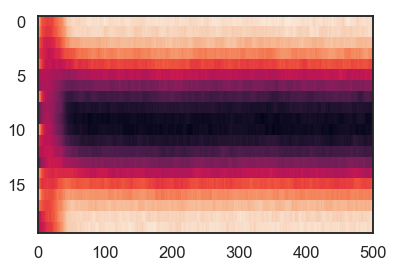

In [991]:
data = np.array(us)  #rep X neu X time array
plt.imshow(np.squeeze(data[-1,:,:]),aspect='auto')

data = np.transpose(data, (0, 2, 1));   #swap dimensions
data = np.reshape(data,(rep*len(time),N));  #combine trials and time
data = data.T  #move cell in front
data.shape

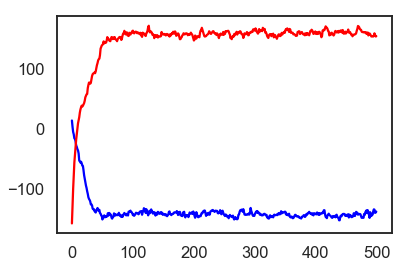

In [992]:
#checking trials
plt.plot(data[0,4500:5000],'b')
plt.plot(data[0,3500:4000],'r')

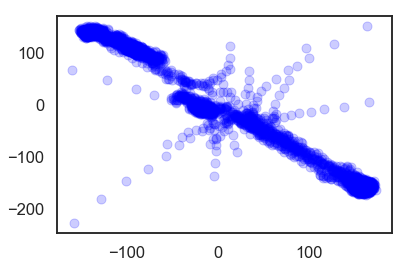

In [1001]:
xx = data[0,:]
yy = data[10,:]

plt.plot(xx,yy,'bo',alpha=0.2)

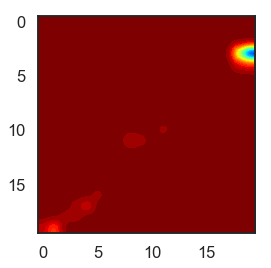

In [994]:
###landscape
steps = 20
Xs = np.arange(min(xx), max(xx), (max(xx)-min(xx))/steps)
Ys = np.arange(min(yy), max(yy), (max(yy)-min(yy))/steps)
# Xs = np.arange(np.mean(xx)-np.std(xx), np.mean(xx)+np.std(xx), 1)
# Ys = np.arange(np.mean(yy)-np.std(yy), np.mean(yy)+np.std(yy), 1)
Pss, xedges, yedges = np.histogram2d(xx, yy, bins=[len(Xs),len(Ys)],normed='True')  #
U = -np.log(Pss.T+10**10)

plt.imshow(U,interpolation='gaussian',cmap='jet')

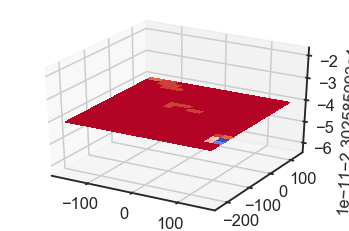

In [995]:
###3D landscape
X, Y = np.meshgrid(Xs, Ys)
Pss, xedges, yedges = np.histogram2d(xx, yy, bins=[len(Xs),len(Ys)],normed='True')
U = -np.log(Pss.T+10**10)

# Plot the surface
from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib import cm
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, U, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


/Users/Macintosh/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


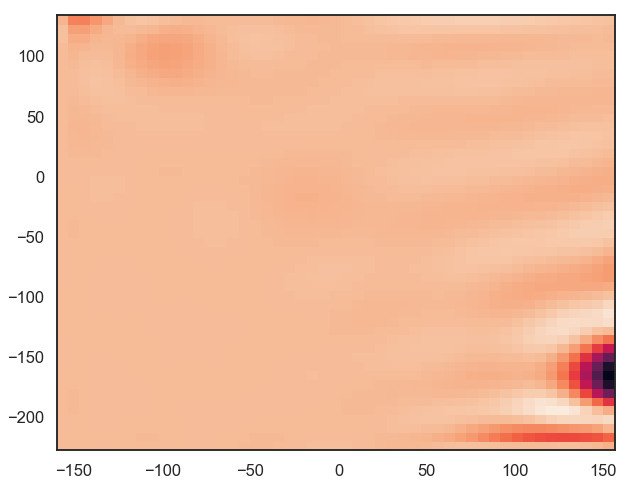

In [996]:
### Gaussian Process regression for energy landscape of Hopfield network

from itertools import product
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from mpl_toolkits.mplot3d import Axes3D

xy = np.vstack((X.reshape(-1),Y.reshape(-1))).T

y = U.reshape(-1)
y = (y-np.mean(y))*10**9  #reasonable range???

# Input space
x1 = np.linspace(xy[:,0].min(), xy[:,0].max()) #p
x2 = np.linspace(xy[:,1].min(), xy[:,1].max()) #q
x = (np.array([x1, x2])).T

kernel = RBF([5,5], (1e-2, 1e2))  # C(1.0, (1e-3, 1e3)) *
gp = GaussianProcessRegressor(kernel=kernel)  #, n_restarts_optimizer=15

gp.fit(xy, y)

x1x2 = np.array(list(product(x1, x2)))
y_pred, MSE = gp.predict(x1x2, return_std=True)  #return mean and std predictions

X0p, X1p = x1x2[:,0].reshape(50,50), x1x2[:,1].reshape(50,50)
Zp = np.reshape(y_pred,(50,50))

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.pcolormesh(X0p, X1p, Zp)


/Users/Macintosh/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Text(0.5, 0, 'Energy U')

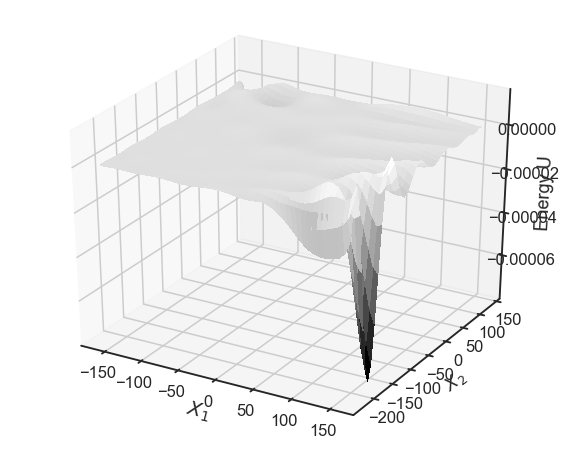

In [997]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.pcolormesh(X0p, X1p, Zp)

ax = fig.add_subplot(111, projection='3d')            
ax.plot_surface(X0p, X1p, Zp, rstride=1, cstride=1, cmap='gray', linewidth=0, antialiased=False)

ax.set_xlabel('$X_1$', fontsize=20, rotation=150)
ax.set_ylabel('$X_2$')
ax.set_zlabel('Energy U')


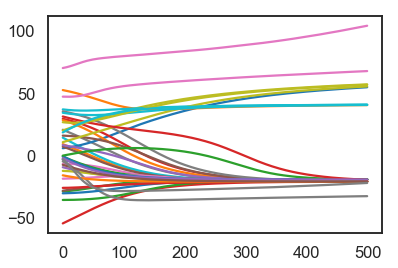

In [998]:
###Energy-landscape dynamcis
gp.predict(np.array([-20,-30])[None,:])  # a way to predict for points

du = .1  #step in landscape
TT = 5
dt = 0.01  #step in time
time = np.arange(0,TT,dt)
ue = np.zeros((2,len(time)))
ue[:,0] = [-0,-0] + np.random.randn(2)*50
alpha = 10**9  #scale the energy potential (like temperature??)

for rr in range(20):
    ue = np.zeros((2,len(time)))
    ue[:,0] = [-0,-0] + np.random.randn(2)*25
    for tt in range(0,len(time)-1):
        dUx = gp.predict(np.array([ue[0,tt]+du,ue[1,tt]])[None,:]) - gp.predict(np.array([ue[0,tt],ue[1,tt]])[None,:])
        dUy = gp.predict(np.array([ue[0,tt],ue[1,tt]+du])[None,:]) - gp.predict(np.array([ue[0,tt],ue[1,tt]])[None,:])
        ue[:,tt+1] = ue[:,tt] + alpha*dt*-( np.squeeze(np.array([dUx, dUy]))/(2*du) )
    plt.plot(ue.T);

In [901]:
###PCA test
Xp = data.copy()
C = np.cov(Xp)
uu,ss,vv = np.linalg.svd(C)
PCs = np.dot(uu[:,:3].T,Xp)

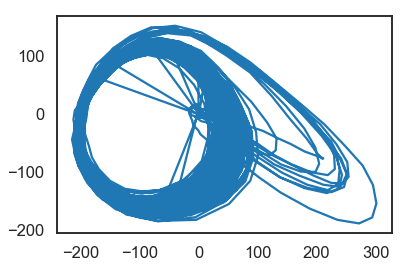

In [902]:
plt.plot(PCs[1,:],PCs[2,:])

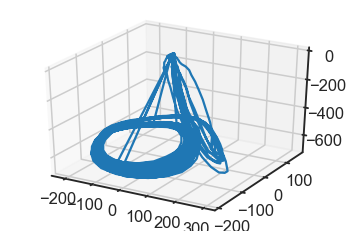

In [903]:
from mpl_toolkits.mplot3d import Axes3D
ax = plt.axes(projection='3d')
ax.plot3D(PCs[1,:], PCs[2,:], PCs[0,:])

## Need to include flow field

GP for SDE
-https://github.com/cagatayyildiz/npde/blob/master/demo.ipynb

Variational GP approximation
-https://github.com/vrettasm/VGPA

## Diffusion map (test)

https://pydiffmap.readthedocs.io/en/master/

In [708]:
from pydiffmap import diffusion_map as dm

In [762]:
swiss_roll = np.array([X.reshape(-1), Y.reshape(-1), y]).transpose()


# initialize Diffusion map object.
neighbor_params = {'n_jobs': -1, 'algorithm': 'ball_tree'}

mydmap = dm.DiffusionMap.from_sklearn(n_evecs=2, k=200, epsilon='bgh', alpha=1.0, neighbor_params=neighbor_params)
# fit to data and return the diffusion map.
dmap = mydmap.fit_transform(swiss_roll)

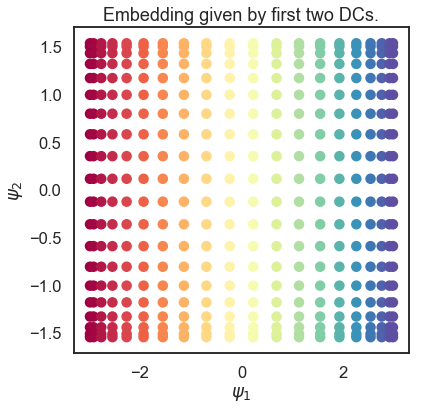

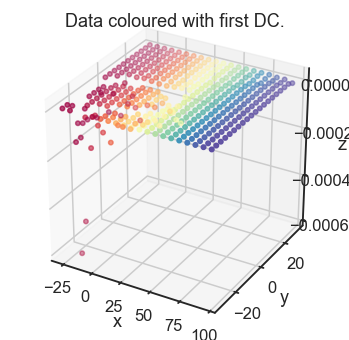

In [763]:
embedding_plot(mydmap, scatter_kwargs = {'c': dmap[:,0], 'cmap': 'Spectral'})
data_plot(mydmap, dim=3, scatter_kwargs = {'cmap': 'Spectral'})

plt.show()

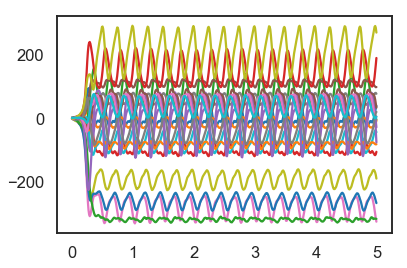

In [883]:
plt.plot(time,u.T);

In [879]:
# set parameters
length_phi = 15   #length of swiss roll in angular direction
length_Z = 15     #length of swiss roll in z direction
sigma = 0.1       #noise strength
m = 10000         #number of samples

# create dataset
phi = length_phi*np.random.rand(m)
xi = np.random.rand(m)
Z = length_Z*np.random.rand(m)
X = 1./6*(phi + sigma*xi)*np.sin(phi)
Y = 1./6*(phi + sigma*xi)*np.cos(phi)

swiss_roll = np.array([X, Y, Z]).transpose()

# check that we have the right shape
print(swiss_roll.shape)

(10000, 3)


In [880]:
# initialize Diffusion map object.
neighbor_params = {'n_jobs': -1, 'algorithm': 'ball_tree'}

mydmap = dm.DiffusionMap.from_sklearn(n_evecs=2, k=200, epsilon='bgh', alpha=1.0, neighbor_params=neighbor_params)
# fit to data and return the diffusion map.
dmap = mydmap.fit_transform(swiss_roll)

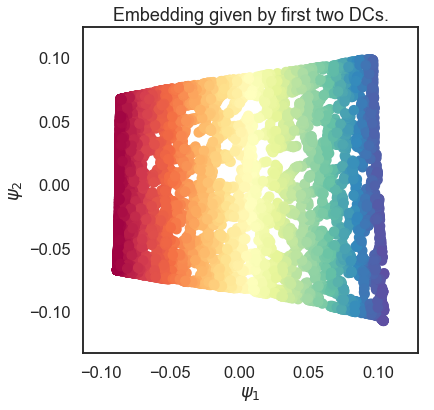

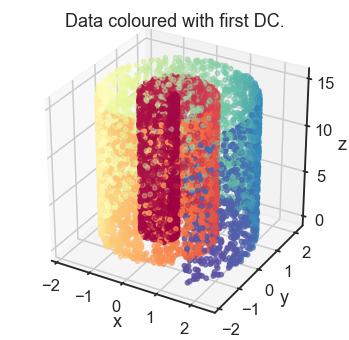

In [881]:
from pydiffmap.visualization import embedding_plot, data_plot

embedding_plot(mydmap, scatter_kwargs = {'c': dmap[:,0], 'cmap': 'Spectral'})
data_plot(mydmap, dim=3, scatter_kwargs = {'cmap': 'Spectral'})

plt.show()